In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib
import colors as cols

data = pd.read_csv('../Prepared_Data/data.csv')

In [30]:
##### Set the Plot Sheme #####

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

# set plotting stylesheet
# plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))
%run -i plot_parameter.py

In [31]:
##### Cluster data #####

# remove rows that have values missing
data = data.dropna()

# calculate correlation between 'number of parts' and each set factor
correlation_with_number_of_parts = data[['year', 'number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                                   'number_of_categories', 'number_of_unique_parts', 'number_of_different_parts',
                                   'not_unique_parts', 'proportion_unique_to_not_unique']].corr()['number_of_parts']

print(correlation_with_number_of_parts)

# calculate correlation between 'complexity score' and each set feature
correlation_with_complexity = data[['year', 'number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                                   'number_of_categories', 'number_of_unique_parts', 'number_of_different_parts',
                                   'not_unique_parts', 'proportion_unique_to_not_unique', 'complexity_score']].corr()['complexity_score']
print(correlation_with_complexity)

# select relevant columns for clustering
columns_for_clustering = ['number_of_parts', 'number_of_different_parts',
                    'number_of_unique_parts', 'minifig_quantitiy', 
                    'number_of_categories', 'number_of_colors', 'complexity_score']

# extract the selected columns for clustering
data_for_clustering = data[columns_for_clustering]

# impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
data_for_clustering_imputed = imputer.fit_transform(data_for_clustering)

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering_imputed)

# determine the optimal number of clusters using the elbow method
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

year                               0.163838
number_of_parts                    1.000000
minifig_quantitiy                  0.410041
number_of_colors                   0.527134
number_of_categories               0.538492
number_of_unique_parts             0.526621
number_of_different_parts          0.740795
not_unique_parts                   0.998798
proportion_unique_to_not_unique   -0.117595
Name: number_of_parts, dtype: float64
year                               0.195816
number_of_parts                    0.984859
minifig_quantitiy                  0.475633
number_of_colors                   0.625072
number_of_categories               0.634028
number_of_unique_parts             0.647609
number_of_different_parts          0.843312
not_unique_parts                   0.976241
proportion_unique_to_not_unique   -0.120877
complexity_score                   1.000000
Name: complexity_score, dtype: float64


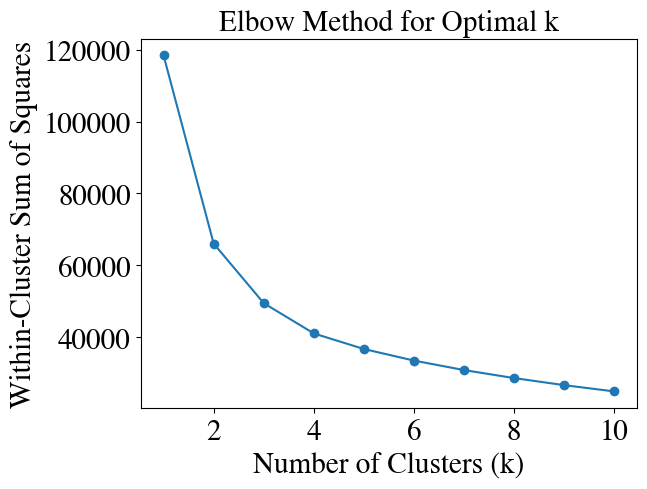

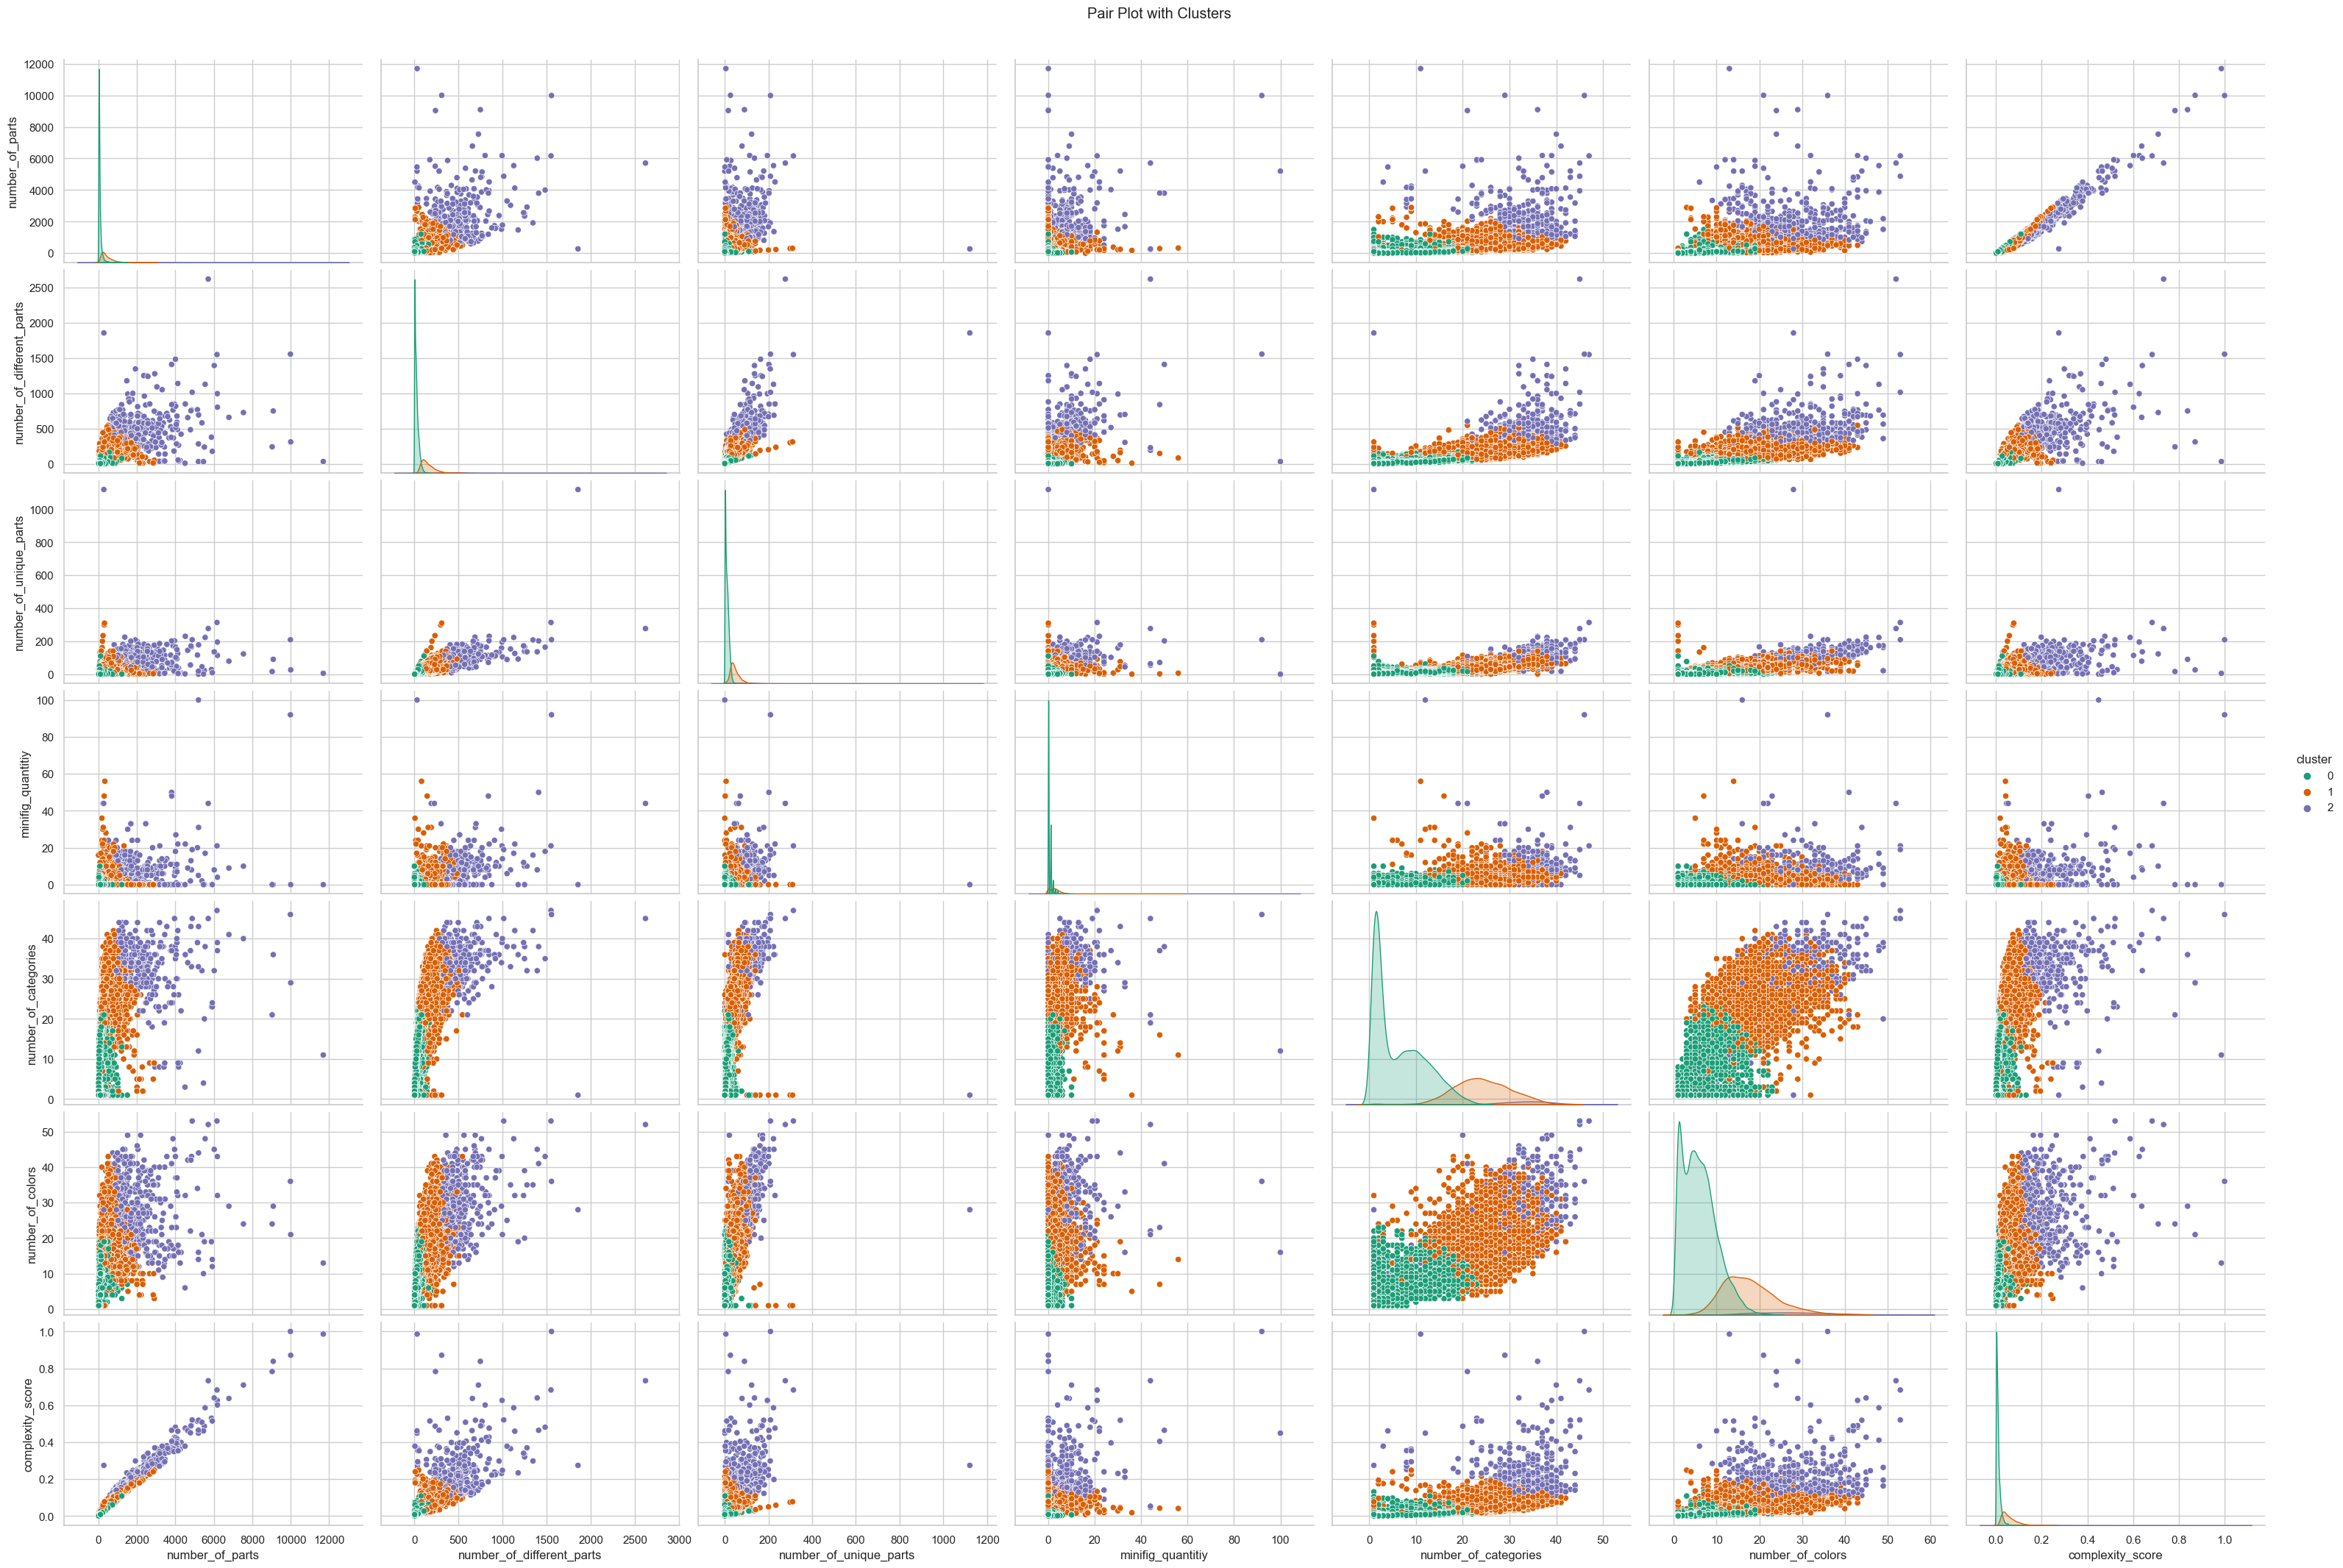

In [32]:
##### Plot the elbow method graph #####

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

# based on the elbow method, choose the optimal number of clusters
optimal_k = 3  # You can change this based on the plot

# perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

# add the cluster labels to the original DataFrame
data['cluster'] = clusters

# visualize the clusters using a pair plot
sns.set(style="whitegrid")
sns.pairplot(data, hue='cluster', palette='Dark2', vars=columns_for_clustering, height=3, aspect=1.5)
plt.suptitle('Pair Plot with Clusters', y=1.02)
plt.show()

In [33]:
##### Print means of different factors in the clusters #####

# select only numeric columns for aggregation
numeric_columns = ['number_of_parts', 'number_of_different_parts',
                    'number_of_unique_parts', 'minifig_quantitiy', 
                    'number_of_categories', 'number_of_colors', 'complexity_score']

# ensure numeric columns have the correct data types (convert if necessary)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# drop rows with missing values
df = data.dropna(subset=numeric_columns)

# group by cluster and calculate mean for numeric columns
cluster_means = data.groupby('cluster')[numeric_columns].mean()

# display the cluster means
print(cluster_means)

         number_of_parts  number_of_different_parts  number_of_unique_parts   
cluster                                                                       
0              62.152951                  22.823932                9.397314  \
1             440.593698                 149.894963               45.040344   
2            2153.527650                 486.170507               97.375576   

         minifig_quantitiy  number_of_categories  number_of_colors   
cluster                                                              
0                 0.472202              6.375010          6.015710  \
1                 3.058009             24.079255         17.700883   
2                 7.716590             32.691244         27.771889   

         complexity_score  
cluster                    
0                0.008578  
1                0.056663  
2                0.234940  


   number_of_parts  number_of_different_parts  number_of_unique_parts   
0         0.023399                   0.034640                0.061900  \
1         0.165869                   0.227496                0.296683   
2         0.810732                   0.737864                0.641417   

   minifig_quantitiy  number_of_categories  number_of_colors  complexity_score  
0           0.041985              0.100957          0.116836          0.028575  
1           0.271900              0.381330          0.343783          0.188763  
2           0.686114              0.517713          0.539381          0.782662  


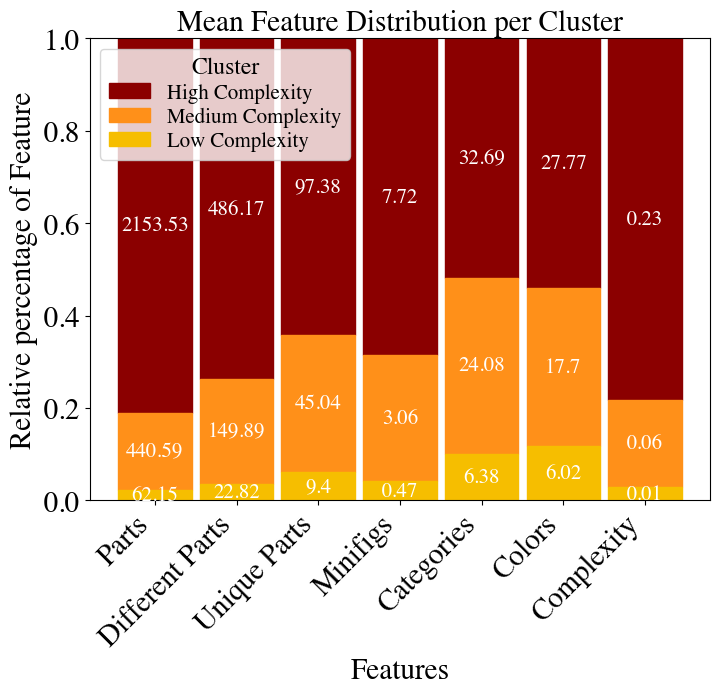

In [34]:
##### Plot the proportion of features in the different clusters #####

# reset plot scheme
%run -i plot_parameter.py

# create feature data
feature_data = {
    'number_of_parts': cluster_means['number_of_parts'].values,
    'number_of_different_parts': cluster_means['number_of_different_parts'].values,
    'number_of_unique_parts': cluster_means['number_of_unique_parts'].values,
    'minifig_quantitiy': cluster_means['minifig_quantitiy'].values,
    'number_of_categories': cluster_means['number_of_categories'].values,
    'number_of_colors': cluster_means['number_of_colors'].values,
    'complexity_score': cluster_means['complexity_score'].values
}

feature_data = pd.DataFrame(feature_data)

# normalize the data so that each array for each feature adds up to 1
normalized_data = feature_data.div(feature_data.sum(axis=0), axis=1)
print(normalized_data)

fig, ax = plt.subplots(figsize=(8,6))

# calculate clusters
cluster_0 = normalized_data.values[0]
cluster_1 = normalized_data.values[1]
cluster_2 = normalized_data.values[2]
cluster_0_plus_cluster_1 = cluster_0 + cluster_1

# Round and convert to strings
cluster_0_labels = [str(round(value, 2)) for value in cluster_means.values[0]]
cluster_1_labels = [str(round(value, 2)) for value in cluster_means.values[1]]
cluster_2_labels = [str(round(value, 2)) for value in cluster_means.values[2]]

features = ['Parts', 'Different Parts', 'Unique Parts', 'Minifigs', 'Categories', 'Colors', 
            'Complexity']

# plot the normalized features

b = ax.bar(features, cluster_2, bottom=cluster_0_plus_cluster_1, color=cols.red, label= "High Complexity", edgecolor=cols.red, width = 0.9)
ax.bar_label(b, padding=0, labels=cluster_2_labels, color = 'w', fontsize = 15, label_type="center")

b = ax.bar(features, cluster_1, bottom=cluster_0, color=cols.orange, label= "Medium Complexity", edgecolor=cols.orange, width = 0.9)
ax.bar_label(b, padding=0, labels=cluster_1_labels, color = 'w', fontsize = 15, label_type="center")

b = ax.bar(features, cluster_0, color=cols.yellow, label="Low Complexity", edgecolor=cols.yellow, width = 0.9)
ax.bar_label(b, padding=0, labels=np.array(cluster_0_labels), color = 'w', fontsize = 15, label_type="center")

# add title, labels and x-ticks
ax.set_xticks(features)
ax.set_xlabel("Features")
ax.set_title('Mean Feature Distribution per Cluster')
ax.legend(title='Cluster', labelspacing= 0.2, loc='upper left')
ax.set_ylabel("Relative percentage of Feature")
ax.set_ylim(0,1)
plt.xticks(rotation=45, ha='right')

# save plot
plt.savefig('../Images/Clusters_features.pdf', bbox_inches=matplotlib.transforms.Bbox([[0.0, -1.25], [7.5, 6.0]]))

# show plot
plt.show()

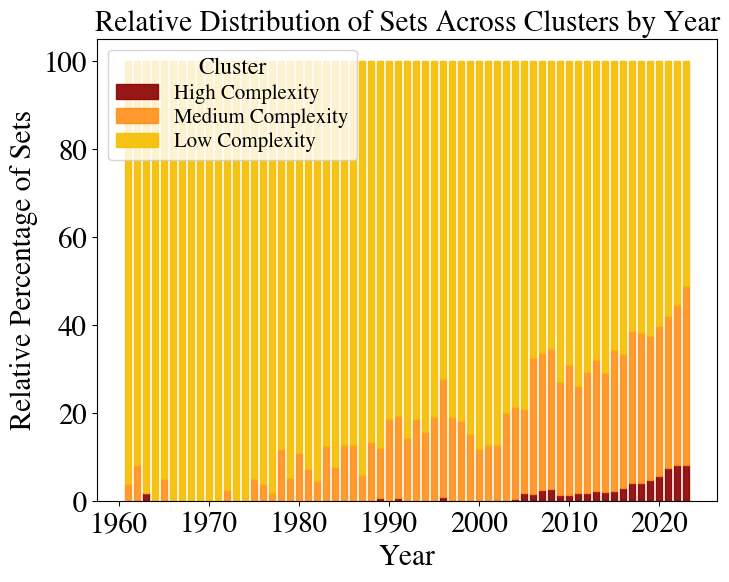

In [35]:
##### Plot the relative percentage of sets in each cluster for every year #####

# group by year and cluster, and calculate the relative percentage
cluster_year_counts = df.groupby(['year', 'cluster']).size().reset_index(name='set_count')
cluster_year_counts['relative_percentage'] = (cluster_year_counts.groupby('year')['set_count'].transform(lambda x: x / x.sum()) * 100)

# pivot the DataFrame to have clusters as columns
pivot_df = cluster_year_counts.pivot(index='year', columns='cluster', values='relative_percentage').fillna(0)

# create the figure and axes
fig, ax = plt.subplots(figsize=(8,6))

# plot the stacked bar plot using ax.bar
years = pivot_df.index
clusters_plot = pivot_df.columns
bottom_values = pd.Series(0, index=years)
colors = [cols.red, cols.orange, cols.yellow]

cluster_labels = {
    0: 'Low Complexity',
    1: 'Medium Complexity',
    2: 'High Complexity'}

# reverse the order of clusters
for cluster, color in zip(reversed(clusters_plot), colors):
    ax.bar(
        years,
        pivot_df[cluster],
        bottom=bottom_values,
        label=cluster_labels[cluster],
        alpha=0.9,
        color=color,
        edgecolor=color,
        width=0.65 # 0.603
    )
    bottom_values += pivot_df[cluster]

# add title, labels and x-ticks
ax.set_title('Relative Distribution of Sets Across Clusters by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Relative Percentage of Sets')
plt.tick_params(axis='x', which='major', bottom=True, width=0.7)    
ax.legend(title='Cluster', labelspacing= 0.2, loc='upper left')

# save plot
plt.savefig('../Images/Clusters.pdf', bbox_inches=matplotlib.transforms.Bbox([[0.0, 0.0], [7.5, 6.0]]))

# show plot
plt.show()


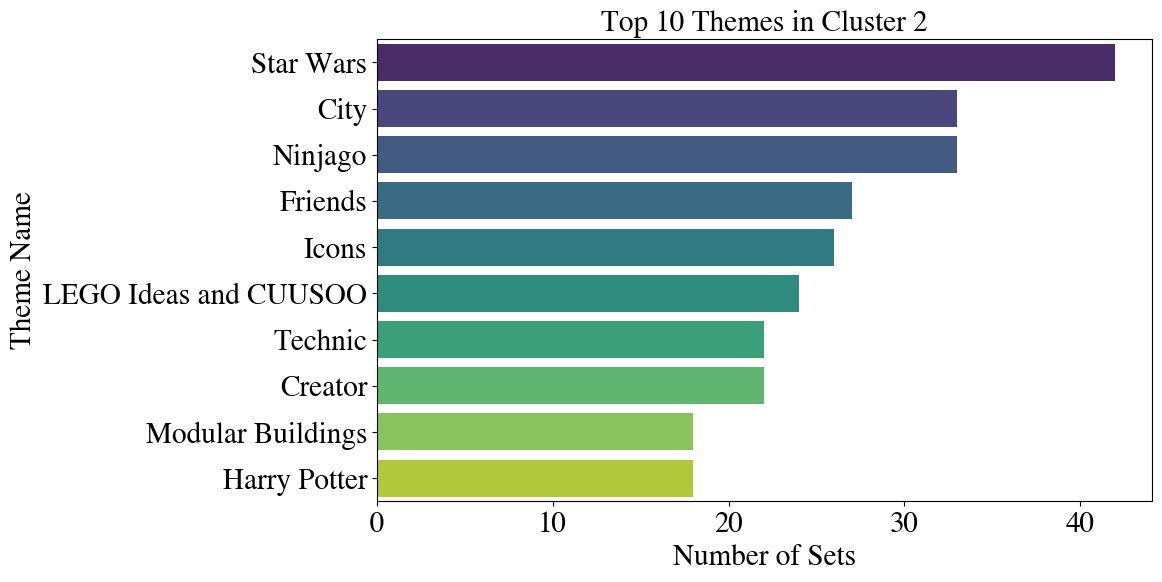

In [36]:
##### Plot 10 most complex themes ##### 

# assuming that cluster 2 accounts for the most complex sets, find out which themes are the most complex
cluster_2_df = df[df['cluster'] == 2]

# get the 10 most common themes in Cluster 2
top_10_themes_cluster_2 = cluster_2_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_2.values, y=top_10_themes_cluster_2.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 2')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()

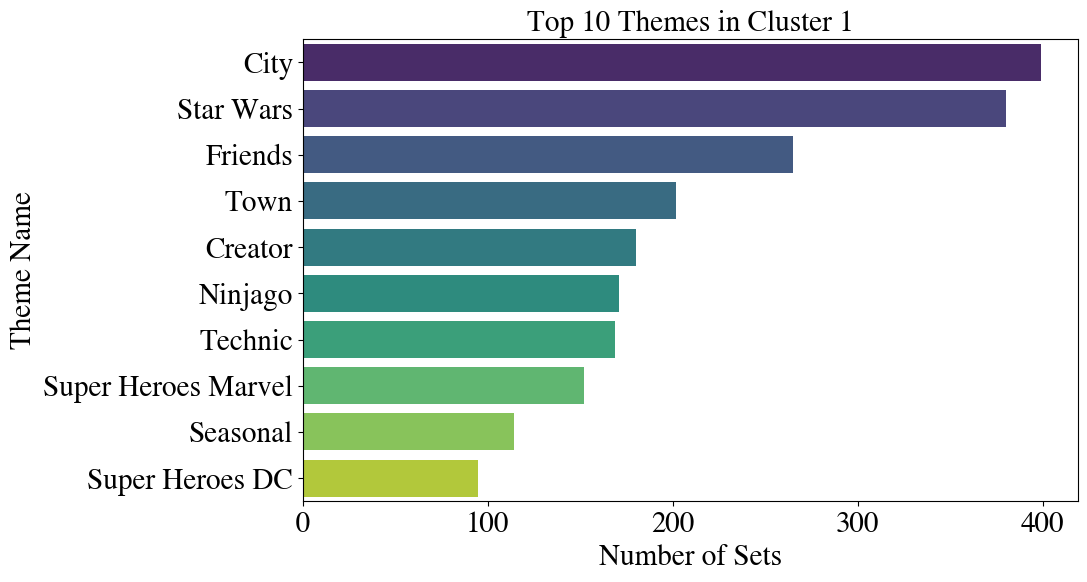

In [37]:
##### 10 middle complex themes #####

# assuming that cluster 1 accounts for the middle complex sets
cluster_1_df = df[df['cluster'] == 1]

# get the 10 most common themes in Cluster 1
top_10_themes_cluster_1 = cluster_1_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_1.values, y=top_10_themes_cluster_1.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 1')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()


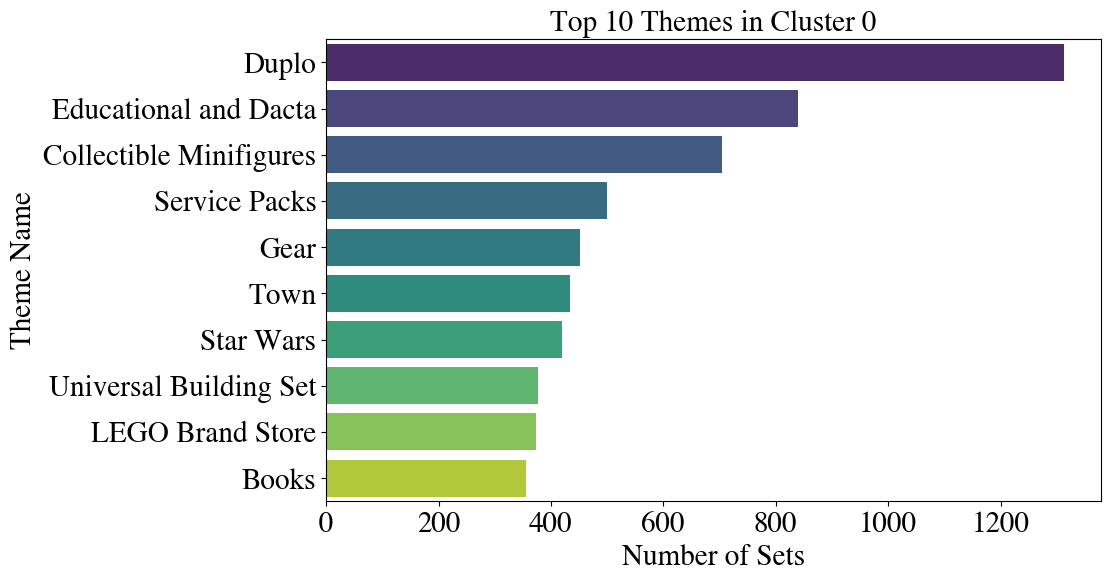

In [38]:
##### 10 low complex themes #####

# assuming that cluster 2 accounts for the lowest complex sets
cluster_0_df = df[df['cluster'] == 0]

# get the 10 most common themes in Cluster 1
top_10_themes_cluster_0 = cluster_0_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_0.values, y=top_10_themes_cluster_0.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 0')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()

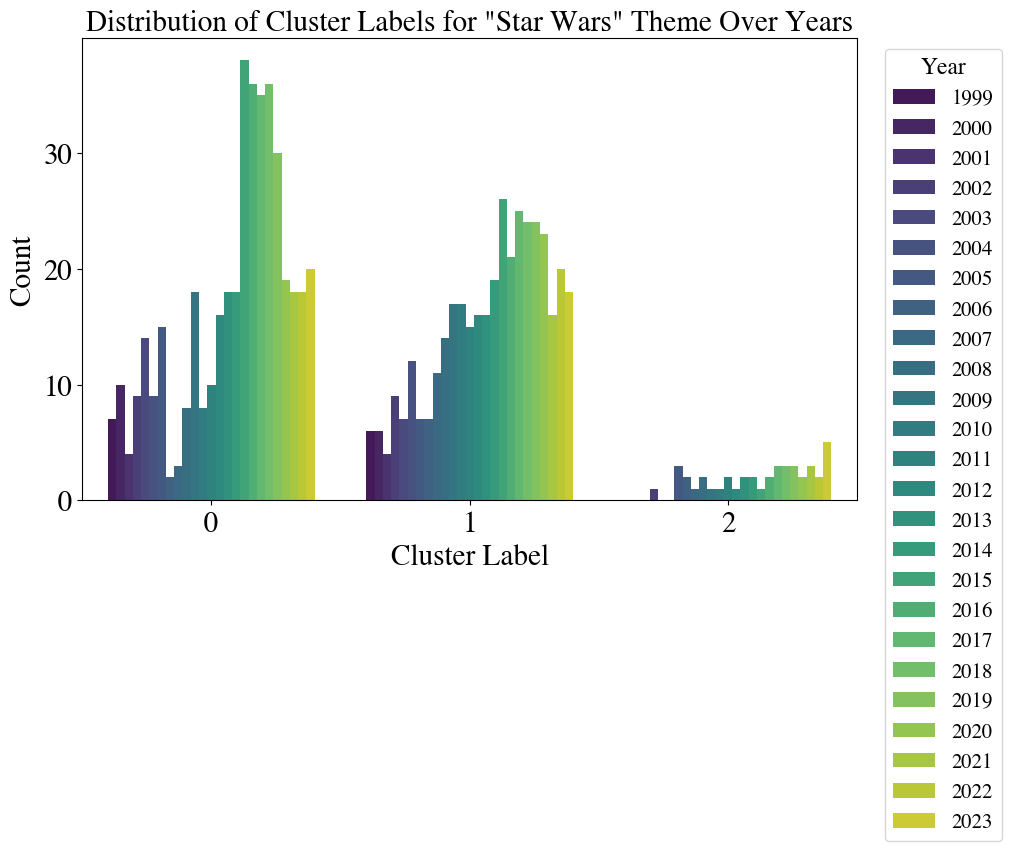

In [39]:
##### Plot the change of Star Wars complexity #####

# filter the DataFrame for sets with theme name "Star Wars"
star_wars_df = df[df['theme_name'] == 'Star Wars']

# plot the count of cluster labels for "Star Wars" theme over the years
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='year', data=star_wars_df, palette='viridis')
plt.title('Distribution of Cluster Labels for "Star Wars" Theme Over Years')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

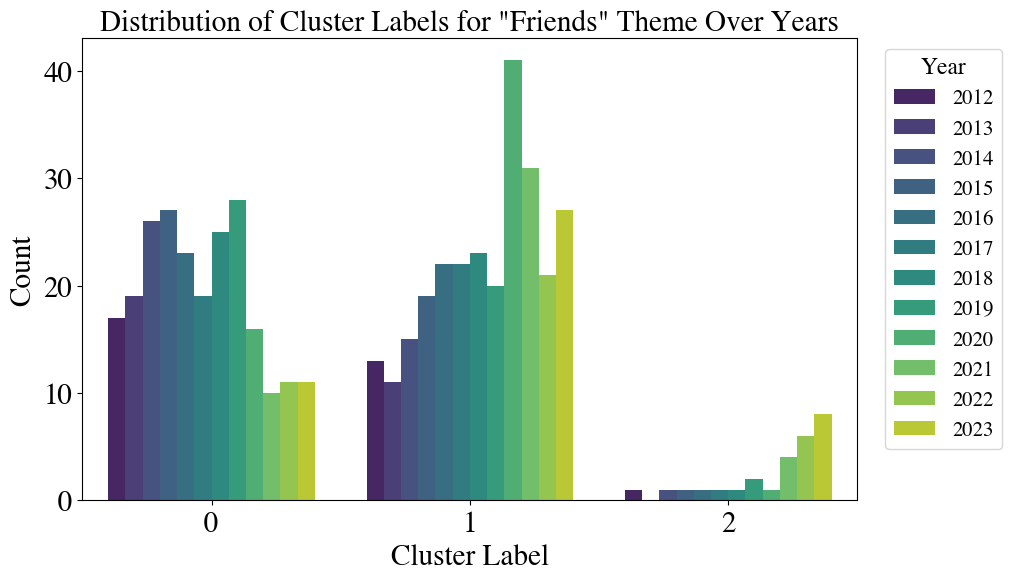

In [40]:
##### Plot the change of Friends complexity #####

# filter the DataFrame for sets with theme name "Star Wars"
friends_df = df[df['theme_name'] == 'Friends']

# plot the count of cluster labels for "Friends" theme over the years
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='year', data=friends_df, palette='viridis')
plt.title('Distribution of Cluster Labels for "Friends" Theme Over Years')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()